# SageMaker Clarify Online Explainability on Multi-Model Endpoint

## Runtime
This notebook takes approximately 20 minutes to run

## Contents

* [Introduction](#Introduction)
* [General Setup](#General-Setup)
  * [Install dependencies](#Install-dependencies)
  * [Import libraries](#Import-libraries)
  * [Set configurations](#Set-configurations)
  * [Create serializer and deserializer](#Create-serializer-and-deserializer)
  * [For visualization](#For-visualization)
* [Prepare data](#Prepare-data)
  * [Split a given dataset into train, validation, and test](#Split-a-given-dataset-into-train,-validation,-and-test)
* [Train multiple house value prediction models](#Train-multiple-house-value-prediction-models)
  * [Launch a single training job for a given housing location](#Launch-a-single-training-job-for-a-given-housing-location)
  * [Kick off a model training job for each housing location](#Kick-off-a-model-training-job-for-each-housing-location)
  * [Wait for all model training to finish](#Wait-for-all-model-training-to-finish)
  * [Move model artifacts to an S3 location](#Move-model-artifacts-to-an-S3-location)
* [Create Endpoint](#Create-Endpoint)
  * [Create model](#Create-model)
  * [Create endpoint config](#Create-endpoint-config)
  * [Create endpoint](#Create-endpoint)
* [Invoke endpoint](#Invoke-endpoint)
  * [Single record request: First Model](#Single-record-request:-First-Model)
  * [Single record request: Second Model](#Single-record-request:-Second-Model)
  * [Single record request, no explanation](#Single-record-request,-no-explanation)
  * [Batch request](#Batch-request)
* [Cleanup](#Cleanup)

## Introduction

Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models.

With [Amazon SageMaker multi-model endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html), customers can create an endpoint that seamlessly hosts up to thousands of models. These endpoints are well suited to use cases where any one of a large number of models is needed, which can be served from a common inference container to save inference costs, needs to be invokable on-demand and where it is acceptable for infrequently invoked models to incur some additional latency. For applications which require consistently low inference latency, an endpoint deploying a single model is still the best choice.

This example notebook showcases how to create a multi-model endpoint with online explainability enabled. To demonstrate how multi-model endpoints are created and used, this notebook provides an example using a set of XGBoost models that each predict housing prices for a single location. Then the example notebook walks you through key terms and concepts needed to understand SageMaker Clarify, create an endpoint configuration with the new SageMaker Clarify explainer configuration and create an endpoint using the same explainer configuration.

## General Setup

We recommend you use `Python 3 (Data Science)` kernel on SageMaker Studio or `conda_python3` kernel on SageMaker Notebook Instance.

### Install dependencies

In [2]:
!pip install sagemaker --upgrade
!pip install boto3 --upgrade
!pip install shap --upgrade
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.5/665.5 kB 5.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 37.8 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.131.0-py2.py3-none-any.whl size=902777 sha256=279665f89866f4c44ba319e09b05cab022d561c99dbea3f484a16ac24bf49adb
  Stored in directory: /root/.cache/pip/wheels/11/d3/ea/138a43d71a879b004812719995651323aea22f3045914947de
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.86
    Uninstalling botocore-1.27.86:
      Successfully uninstalled botocore-1.27.86
  Attempting uninstall: boto3
    Found existing installation: boto3 1.24.86
    Uninstalling boto3-1.24.86:
      Successfully uninstalled boto3-1.24.86
  Attempting uninstall: sagemaker
    Found existing installation: sagema

### Import libraries

In [3]:
import boto3
import io
import os
import sagemaker
import shap
import shutil
import time
import pprint
import pandas as pd
import numpy as np
from collections import OrderedDict
from sagemaker import get_execution_role, image_uris, Session
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.utils import unique_name_from_base
from sklearn.model_selection import train_test_split

### Set configurations

In [4]:
boto3_session = boto3.session.Session()
sagemaker_client = boto3.client("sagemaker")
sagemaker_runtime_client = boto3.client("sagemaker-runtime")

# Initialize sagemaker session
sagemaker_session = Session(
    boto_session=boto3_session,
    sagemaker_client=sagemaker_client,
    sagemaker_runtime_client=sagemaker_runtime_client,
)

region = sagemaker_session.boto_region_name
print(f"Region: {region}")

role = get_execution_role()
print(f"Role: {role}")

s3 = boto3.resource("s3")
bucket = sagemaker_session.default_bucket()

prefix = unique_name_from_base("DEMO-MME-OnlineExplainability")
multi_model_artifacts = "multi_model_artifacts"

model_name = f"{prefix}-model"
print(f"Demo model name: {model_name}")
endpoint_config_name = f"{prefix}-endpoint-config"
print(f"Demo endpoint config name: {endpoint_config_name}")
endpoint_name = f"{prefix}-endpoint"
print(f"Demo endpoint name: {endpoint_name}")

# Instance type for training and hosting
instance_type = "ml.m5.xlarge"

Region: us-west-2
Role: arn:aws:iam::000000000000:role/service-role/AmazonSageMaker-ExecutionRole-20220304T121686
Demo model name: DEMO-MME-OnlineExplainability-1675129923-c50d-model
Demo endpoint config name: DEMO-MME-OnlineExplainability-1675129923-c50d-endpoint-config
Demo endpoint name: DEMO-MME-OnlineExplainability-1675129923-c50d-endpoint


### Create serializer and deserializer

CSV serializer to serialize test data to string

In [5]:
csv_serializer = CSVSerializer()

JSON deserializer to deserialize invoke endpoint response

In [6]:
json_deserializer = JSONDeserializer()

### For visualization

SHAP plots are useful visualization tools to interpret the explanations. For example, [SHAP additive force layout](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html) shows how each feature contributes to pushing the base value (also called the expected value which is the mean predictions of the training dataset) to the corresponding prediction. Features that push the prediction higher are in red color, while those push the prediction lower are in blue.

In [7]:
def force_plot(expected_value, shap_values, feature_data, feature_headers):
    """
    Visualize the given SHAP values with an additive force layout.

    For more information: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html
    """
    force_plot_display = shap.plots.force(
        base_value=expected_value,
        shap_values=shap_values,
        features=feature_data,
        feature_names=feature_headers,
        matplotlib=True,
    )


def display_plots(explanations, expected_value, request_records, predictions):
    """
    Display the Model Explainability plots
    """
    per_request_shap_values = OrderedDict()
    feature_headers = []
    for i, record_output in enumerate(explanations):
        per_record_shap_values = []
        if record_output is not None:
            feature_headers = []
            for feature_attribution in record_output:
                per_record_shap_values.append(
                    feature_attribution["attributions"][0]["attribution"][0]
                )
                feature_headers.append(feature_attribution["feature_header"])
            per_request_shap_values[i] = per_record_shap_values

    for record_index, shap_values in per_request_shap_values.items():
        print(
            f"Visualize the SHAP values for Record number {record_index + 1} with Model Prediction: {predictions[0][record_index]}"
        )
        force_plot(
            expected_value,
            np.array(shap_values),
            request_records.iloc[record_index],
            feature_headers,
        )


def visualize_result(result, request_records, expected_value):
    """
    Visualize the output from the endpoint.
    """
    predictions = pd.read_csv(io.StringIO(result["predictions"]["data"]), header=None)
    predictions = predictions.values.tolist()
    print(f"Model Inference output: ")
    for i, model_output in enumerate(predictions):
        print(f"Record: {i + 1}\tModel Prediction: {model_output[0]}")

    if "kernel_shap" in result["explanations"]:
        explanations = result["explanations"]["kernel_shap"]
        display_plots(explanations, expected_value, request_records, predictions)
    else:
        print(f"No Clarify explanations for the record(s)")

## Prepare data
The code below contains helper functions to prepare data in the form of a `1x7` numpy array representing the features of a house.

The first entry in the array is the randomly generated price of a house. The remaining entries are the features (i.e. number of bedroom, square feet, number of bathrooms, etc.).

These functions will be used to prepare data for training, validation, and testing. It will also allow us to submit payloads for inference to test our multi-model endpoint.

In [8]:
NUM_HOUSES_PER_LOCATION = 1000
LOCATIONS = [
    "NewYork_NY",
    "LosAngeles_CA",
    "Chicago_IL",
    "Houston_TX",
    "Dallas_TX",
    "Phoenix_AZ",
    "Philadelphia_PA",
    "SanAntonio_TX",
    "SanDiego_CA",
    "SanFrancisco_CA",
]
PARALLEL_TRAINING_JOBS = 4  # len(LOCATIONS) if your account limits can handle it
MAX_YEAR = 2022
FEATURE_HEADERS = [
    "YEAR_BUILT",
    "SQUARE_FEET",
    "NUM_BEDROOMS",
    "NUM_BATHROOMS",
    "LOT_ACRES",
    "GARAGE_SPACES",
]

In [9]:
def gen_price(house):
    _base_price = int(house["SQUARE_FEET"] * 150)
    _price = int(
        _base_price
        + (10000 * house["NUM_BEDROOMS"])
        + (15000 * house["NUM_BATHROOMS"])
        + (15000 * house["LOT_ACRES"])
        + (15000 * house["GARAGE_SPACES"])
        - (5000 * (MAX_YEAR - house["YEAR_BUILT"]))
    )
    return _price

In [10]:
def gen_random_house():
    _house = {
        "SQUARE_FEET": int(np.random.normal(3000, 750)),
        "NUM_BEDROOMS": np.random.randint(2, 7),
        "NUM_BATHROOMS": np.random.randint(2, 7) / 2,
        "LOT_ACRES": round(np.random.normal(1.0, 0.25), 2),
        "GARAGE_SPACES": np.random.randint(0, 4),
        "YEAR_BUILT": min(MAX_YEAR, int(np.random.normal(1995, 10))),
    }
    _price = gen_price(_house)
    return [
        _price,
        _house["YEAR_BUILT"],
        _house["SQUARE_FEET"],
        _house["NUM_BEDROOMS"],
        _house["NUM_BATHROOMS"],
        _house["LOT_ACRES"],
        _house["GARAGE_SPACES"],
    ]

In [11]:
def gen_houses(num_houses):
    _house_list = []
    for i in range(num_houses):
        _house_list.append(gen_random_house())
    _df = pd.DataFrame(
        _house_list,
        columns=[
            "PRICE",
            "YEAR_BUILT",
            "SQUARE_FEET",
            "NUM_BEDROOMS",
            "NUM_BATHROOMS",
            "LOT_ACRES",
            "GARAGE_SPACES",
        ],
    )
    return _df

### Split a given dataset into train, validation, and test

The code below will generate three sets of data. One set to train, one set for validation and one for testing.

In [12]:
SEED = 7
SPLIT_RATIOS = [0.6, 0.3, 0.1]


def split_data(df):
    # split data into train and test sets
    seed = SEED
    val_size = SPLIT_RATIOS[1]
    test_size = SPLIT_RATIOS[2]

    num_samples = df.shape[0]
    X1 = df.values[:num_samples, 1:]  # keep only the features, skip the target, all rows
    Y1 = df.values[:num_samples, :1]  # keep only the target, all rows

    # Use split ratios to divide up into train/val/test
    X_train, X_val, y_train, y_val = train_test_split(
        X1, Y1, test_size=(test_size + val_size), random_state=seed
    )
    # Of the remaining non-training samples, give proper ratio to validation and to test
    X_test, X_test, y_test, y_test = train_test_split(
        X_val, y_val, test_size=(test_size / (test_size + val_size)), random_state=seed
    )
    # reassemble the datasets with target in first column and features after that
    _train = np.concatenate([y_train, X_train], axis=1)
    _val = np.concatenate([y_val, X_val], axis=1)
    _test = np.concatenate([y_test, X_test], axis=1)

    return _train, _val, _test

## Train multiple house value prediction models

In the follow section, we are setting up the code to train a house price prediction model for each of 4 different cities.

As such, we will launch multiple training jobs asynchronously, using the XGBoost algorithm.

In this notebook, we will be using the AWS Managed XGBoost Image for both training and inference - this image provides native support for launching multi-model endpoints.

In [13]:
# This is references the AWS managed XGBoost container
xgboost_image = image_uris.retrieve(
    region=boto3.Session().region_name, framework="xgboost", version="1.5-1"
)
xgboost_image

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1'

### Launch a single training job for a given housing location
There is nothing specific to multi-model endpoints in terms of the models it will host. They are trained in the same way as all other SageMaker models. Here we are using the XGBoost estimator and not waiting for the job to complete.

In [14]:
def launch_training_job(location):
    # clear out old versions of the data
    s3_bucket = s3.Bucket(bucket)
    full_input_prefix = f"{prefix}/model_prep/{location}"
    s3_bucket.objects.filter(Prefix=full_input_prefix + "/").delete()

    # upload the entire set of data for all three channels
    local_folder = f"data/{location}"
    inputs = sagemaker_session.upload_data(path=local_folder, key_prefix=full_input_prefix)
    print(f"Training data uploaded: {inputs}")

    _job = "xgb-{}".format(location.replace("_", "-"))
    full_output_prefix = f"{prefix}/model_artifacts/{location}"
    s3_output_path = f"s3://{bucket}/{full_output_prefix}"

    xgb = sagemaker.estimator.Estimator(
        xgboost_image,
        role,
        instance_count=1,
        instance_type=instance_type,
        output_path=s3_output_path,
        base_job_name=_job,
        sagemaker_session=sagemaker_session,
    )

    xgb.set_hyperparameters(
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.8,
        verbosity=0,
        early_stopping_rounds=5,
        objective="reg:squarederror",
        num_round=25,
    )

    DISTRIBUTION_MODE = "FullyReplicated"

    train_input = sagemaker.inputs.TrainingInput(
        s3_data=inputs + "/train", distribution=DISTRIBUTION_MODE, content_type="csv"
    )

    val_input = sagemaker.inputs.TrainingInput(
        s3_data=inputs + "/val", distribution=DISTRIBUTION_MODE, content_type="csv"
    )

    remote_inputs = {"train": train_input, "validation": val_input}

    xgb.fit(remote_inputs, wait=False)

    # Return the estimator object
    return xgb

### Kick off a model training job for each housing location

In [15]:
def save_data_locally(location, train, val, test):
    os.makedirs(f"data/{location}/train")
    np.savetxt(f"data/{location}/train/{location}_train.csv", train, delimiter=",", fmt="%.2f")

    os.makedirs(f"data/{location}/val")
    np.savetxt(f"data/{location}/val/{location}_val.csv", val, delimiter=",", fmt="%.2f")

    os.makedirs(f"data/{location}/test")
    np.savetxt(f"data/{location}/test/{location}_test.csv", test, delimiter=",", fmt="%.2f")

In [16]:
estimators = []

shutil.rmtree("data", ignore_errors=True)

for loc in LOCATIONS[:PARALLEL_TRAINING_JOBS]:
    _houses = gen_houses(NUM_HOUSES_PER_LOCATION)
    _train, _val, _test = split_data(_houses)
    save_data_locally(loc, _train, _val, _test)
    estimator = launch_training_job(loc)
    estimators.append(estimator)

print()
print(
    f"{len(estimators)} training jobs launched: {[x.latest_training_job.job_name for x in estimators]}"
)

INFO:sagemaker:Creating training-job with name: xgb-NewYork-NY-2023-01-31-01-52-15-585


Training data uploaded: s3://sagemaker-us-west-2-000000000000/DEMO-MME-OnlineExplainability-1675129923-c50d/model_prep/NewYork_NY


INFO:sagemaker:Creating training-job with name: xgb-LosAngeles-CA-2023-01-31-01-52-16-229


Training data uploaded: s3://sagemaker-us-west-2-000000000000/DEMO-MME-OnlineExplainability-1675129923-c50d/model_prep/LosAngeles_CA


INFO:sagemaker:Creating training-job with name: xgb-Chicago-IL-2023-01-31-01-52-19-246


Training data uploaded: s3://sagemaker-us-west-2-000000000000/DEMO-MME-OnlineExplainability-1675129923-c50d/model_prep/Chicago_IL


INFO:sagemaker:Creating training-job with name: xgb-Houston-TX-2023-01-31-01-52-20-842


Training data uploaded: s3://sagemaker-us-west-2-000000000000/DEMO-MME-OnlineExplainability-1675129923-c50d/model_prep/Houston_TX

4 training jobs launched: ['xgb-NewYork-NY-2023-01-31-01-52-15-585', 'xgb-LosAngeles-CA-2023-01-31-01-52-16-229', 'xgb-Chicago-IL-2023-01-31-01-52-19-246', 'xgb-Houston-TX-2023-01-31-01-52-20-842']


### Wait for all model training to finish

In [17]:
def wait_for_training_job_to_complete(estimator):
    job = estimator.latest_training_job.job_name
    print(f"Waiting for job: {job}")
    status = estimator.latest_training_job.describe()["TrainingJobStatus"]
    while status == "InProgress":
        time.sleep(45)
        status = estimator.latest_training_job.describe()["TrainingJobStatus"]
        if status == "InProgress":
            print(f"{job} job status: {status}")
    print(f"DONE. Status for {job} is {status}\n")

In [18]:
for est in estimators:
    wait_for_training_job_to_complete(est)

Waiting for job: xgb-NewYork-NY-2023-01-31-01-52-15-585
xgb-NewYork-NY-2023-01-31-01-52-15-585 job status: InProgress
xgb-NewYork-NY-2023-01-31-01-52-15-585 job status: InProgress
DONE. Status for xgb-NewYork-NY-2023-01-31-01-52-15-585 is Completed

Waiting for job: xgb-LosAngeles-CA-2023-01-31-01-52-16-229
DONE. Status for xgb-LosAngeles-CA-2023-01-31-01-52-16-229 is Completed

Waiting for job: xgb-Chicago-IL-2023-01-31-01-52-19-246
DONE. Status for xgb-Chicago-IL-2023-01-31-01-52-19-246 is Completed

Waiting for job: xgb-Houston-TX-2023-01-31-01-52-20-842
DONE. Status for xgb-Houston-TX-2023-01-31-01-52-20-842 is Completed



### Move model artifacts to an S3 location

In [19]:
# This is where our MME will read models from on S3.
model_data_prefix = f"s3://{bucket}/{prefix}/{multi_model_artifacts}/"

from urllib.parse import urlparse

for est in estimators:
    artifact_path = est.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
    model_file_name = artifact_path.split("/")[-4] + ".tar.gz"
    url_object = urlparse(artifact_path, allow_fragments=False)
    copy_source = {"Bucket": bucket, "Key": url_object.path[1:]}
    s3.meta.client.copy(copy_source, bucket, f"{prefix}/{multi_model_artifacts}/{model_file_name}")

## Create Endpoint

### Create model
The following parameters are required to create SageMaker model for multi-model use case:

* `ExecutionRoleArn`: The ARN of the IAM role that Amazon SageMaker can assume to access the model artifacts/ docker images for deployment

* `ModelName`: Name of the SageMaker model.

* `Containers`: Array of [ContainerDefinition](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html) objects. For multi-model endpoint use case there should be a container with `Mode` as `MultiModel`.

In [20]:
container = {"Image": xgboost_image, "ModelDataUrl": model_data_prefix, "Mode": "MultiModel"}
response = sagemaker_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, Containers=[container]
)

### Create endpoint config

Create an endpoint configuration by calling the `create_endpoint_config` API. Here, supply the same `model_name` used in the `create_model` API call. The `create_endpoint_config` now supports the additional parameter `ClarifyExplainerConfig` to enable the Clarify explainer. The SHAP baseline is mandatory, it can be provided either as inline baseline data (the `ShapBaseline` parameter) or by a S3 baseline file (the `ShapBaselineUri` parameter). Baseline dataset type shall be the same as input dataset type, and baseline samples shall only include features. For more details on baseline selection please [refer this documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html). 

Please see the [`create_endpoint_config` API documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html) for the details on other config parameters.

In [21]:
# For our use case here we will choose a baseline, as per the average of the ranges we used, while
# generating random house dataset above.
baseline = [1995, 3000, 4, 2, 1, 2]

In [22]:
create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
    ExplainerConfig={
        "ClarifyExplainerConfig": {
            "ShapConfig": {
                "ShapBaselineConfig": {"ShapBaseline": csv_serializer.serialize(baseline)}
            },
            "InferenceConfig": {"FeatureHeaders": FEATURE_HEADERS},
        }
    },
)

print("Endpoint config ARN: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint config ARN: arn:aws:sagemaker:us-west-2:000000000000:endpoint-config/demo-mme-onlineexplainability-1675129923-c50d-endpoint-config


### Create endpoint

Once you have your model and endpoint configuration ready, use the `create_endpoint` API to create your endpoint. The `endpoint_name` must be unique within an AWS Region in your AWS account. The `create_endpoint` API is synchronous in nature and returns an immediate response with the endpoint status being `Creating` state.

In [23]:
sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:000000000000:endpoint/demo-mme-onlineexplainability-1675129923-c50d-endpoint',
 'ResponseMetadata': {'RequestId': 'd759cc37-ff2e-464e-8563-3327d76cba4f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd759cc37-ff2e-464e-8563-3327d76cba4f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Tue, 31 Jan 2023 01:55:23 GMT'},
  'RetryAttempts': 0}}

Wait for the endpoint to be in "In-Service" state.

In [24]:
sagemaker_session.wait_for_endpoint(endpoint_name)

-----!

{'EndpointName': 'DEMO-MME-OnlineExplainability-1675129923-c50d-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:000000000000:endpoint/demo-mme-onlineexplainability-1675129923-c50d-endpoint',
 'EndpointConfigName': 'DEMO-MME-OnlineExplainability-1675129923-c50d-endpoint-config',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:9558382c25c9bdbe602269e129fb3578dfa6ce6e2a14bae35a9d821dbc51ce74',
     'ResolutionTime': datetime.datetime(2023, 1, 31, 1, 55, 25, 575000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 1, 31, 1, 55, 24, 225000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 1, 31, 1, 57, 28,

## Invoke endpoint

There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Below are the several combination of endpoint invocation, call them one by one and visualize the explanations by running the subsequent cell. 

### Single record request: First Model

Put only one record in the request body, and then send the request to the endpoint to get its predictions and explanations. Invoke for a particular model by specifying `TargetModel` in request object. For this example we will be invoking for model: `Chicago_IL.tar.gz`

We can use SHAP plots to visualize the result. [SHAP additive force layout](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html) shows how each feature contributes to pushing the base value (also called the expected value which is the mean predictions of the training dataset) to the corresponding prediction. Features that push the prediction higher are in red color, while those push the prediction lower are in blue.

The expected value is the average of the model predictions over the baseline. Here we predict the baseline data and then compute the expected value. Only the predictions are needed, so the `EnableExplanations` parameter is used to disable the explanations.

In [25]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Chicago_IL.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(baseline),
    EnableExplanations="`false`",  # Do not provide explanations
)
json_object = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
expected_value = float(
    pd.read_csv(io.StringIO(json_object["predictions"]["data"]), header=None)
    .astype(float)
    .mean(axis=1)
)
print(f"expected value: {expected_value}")

expected value: 415321.0625


Invoke endpoint with explanations enabled and visualize results.

In [26]:
request_records = pd.DataFrame([gen_random_house()[1:]])

In [27]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Chicago_IL.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x7f5a62a2dad0>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '654',
                                      'content-type': 'application/json',
                                      'date': 'Tue, 31 Jan 2023 01:57:57 GMT',
                                      'x-amzn-invoked-production-variant': 'AllTraffic',
                                      'x-amzn-requestid': '305d75a6-5df3-47ce-a03c-ac4721959526'},
                      'HTTPStatusCode': 200,
                      'RequestId': '305d75a6-5df3-47ce-a03c-ac4721959526',
                      'RetryAttempts': 0}}


Print the response body which is JSON. Please see the [API documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-online-explainability-invoke-endpoint.html#clarify-online-explainability-response) for its schema.

In [28]:
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [-14963.812499999995]}],
                                    'feature_header': 'YEAR_BUILT'},
                                   {'attributions': [{'attribution': [66400.21874999999]}],
                                    'feature_header': 'SQUARE_FEET'},
                                   {'attributions': [{'attribution': [-2.1827872842550278e-11]}],
                                    'feature_header': 'NUM_BEDROOMS'},
                                   {'attributions': [{'attribution': [10457.187500000004]}],
                                    'feature_header': 'NUM_BATHROOMS'},
                                   {'attributions': [{'attribution': [-1.4551915228366852e-11]}],
                                    'feature_header': 'LOT_ACRES'},
                                   {'attributions': [{'attribution': [4.3655745685100555e-11]}],
                                    'feature_header': 'GARAGE_SPACES'}]]},
 'p

Model Inference output: 
Record: 1	Model Prediction: 477214.65625
Visualize the SHAP values for Record number 1 with Model Prediction: 477214.65625


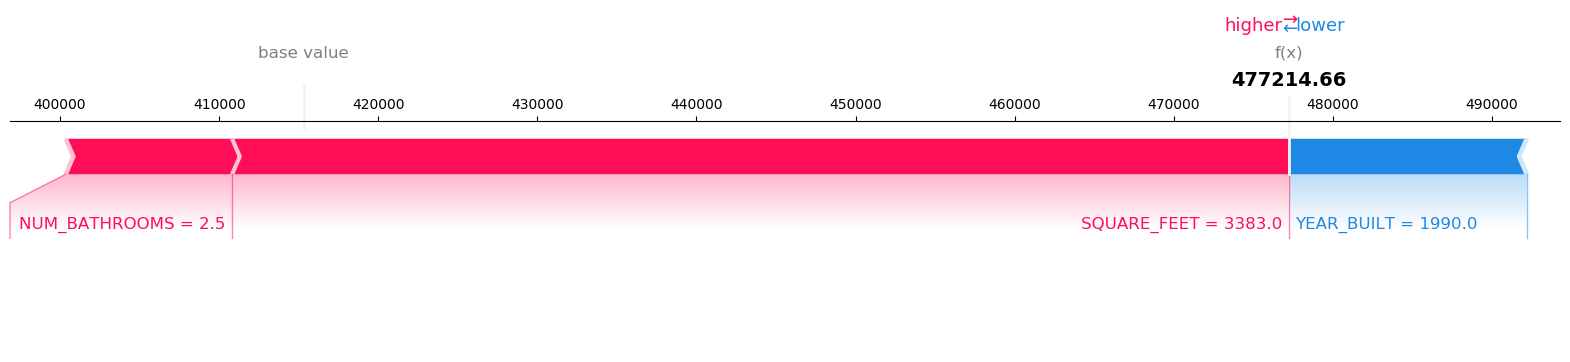

In [29]:
visualize_result(result, request_records, expected_value)

### Single record request: Second Model
Get inference and explanations for same request record with a different model by changing the `TargetModel`. For this example we will be invoking for model: `Houston_TX.tar.gz`. As we are using a different model, results may change for the same baseline.

expected value: 432858.65625
{'Body': <botocore.response.StreamingBody object at 0x7f5a6289e0d0>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '632',
                                      'content-type': 'application/json',
                                      'date': 'Tue, 31 Jan 2023 01:57:59 GMT',
                                      'x-amzn-invoked-production-variant': 'AllTraffic',
                                      'x-amzn-requestid': 'b8c787a4-5310-4865-b4e4-7ce77cfb00a1'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'b8c787a4-5310-4865-b4e4-7ce77cfb00a1',
                      'RetryAttempts': 0}}
{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [-28038.921874999993]}],
                                    'feature_header': 'YEAR_BUILT'},
                                   {'attributions': [{'attribution': [45273.421874999985]}],


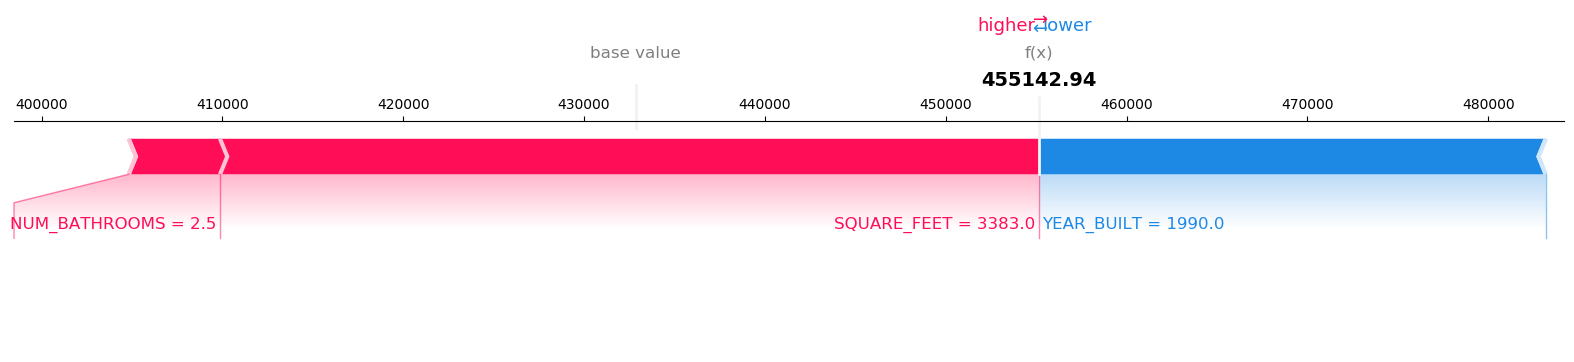

In [30]:
# Get expected value for the same baseline
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Houston_TX.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(baseline),
    EnableExplanations="`false`",  # Do not provide explanations
)
json_object = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
expected_value = float(
    pd.read_csv(io.StringIO(json_object["predictions"]["data"]), header=None)
    .astype(float)
    .mean(axis=1)
)
print(f"expected value: {expected_value}")

# Invoke endpoint and visualise results
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Houston_TX.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
pprint.pprint(response)

result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

visualize_result(result, request_records, expected_value)

### Single record request, no explanation

Use the `EnableExplanations` parameter to disable the explanations for this request.

In [31]:
request_records = pd.DataFrame([gen_random_house()[1:]])
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Houston_TX.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
    EnableExplanations="`false`",  # Do not provide explanations
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {},
 'predictions': {'content_type': 'text/csv', 'data': '532015.4375'},
 'version': '1.0'}


In [32]:
visualize_result(result, request_records, expected_value)

Model Inference output: 
Record: 1	Model Prediction: 532015.4375
No Clarify explanations for the record(s)


### Batch request

Put multiple records in a single request and send the request to the endpoint to get their predictions and explanations.

In [33]:
batch_size = 3
request_records = gen_houses(batch_size).iloc[:, 1:]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    TargetModel="Houston_TX.tar.gz",
    Accept="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [-48240.709554036504]}],
                                    'feature_header': 'YEAR_BUILT'},
                                   {'attributions': [{'attribution': [-26980.432454427064]}],
                                    'feature_header': 'SQUARE_FEET'},
                                   {'attributions': [{'attribution': [-28595.50056966145]}],
                                    'feature_header': 'NUM_BEDROOMS'},
                                   {'attributions': [{'attribution': [52.211425781257276]}],
                                    'feature_header': 'NUM_BATHROOMS'},
                                   {'attributions': [{'attribution': [-7137.843831380198]}],
                                    'feature_header': 'LOT_ACRES'},
                                   {'attributions': [{'attribution': [7234.4624837239535]}],
                                    'feature_header': 'GARAGE_SPACES'}],
                 

Model Inference output: 
Record: 1	Model Prediction: 329190.84375
Visualize the SHAP values for Record number 1 with Model Prediction: 329190.84375


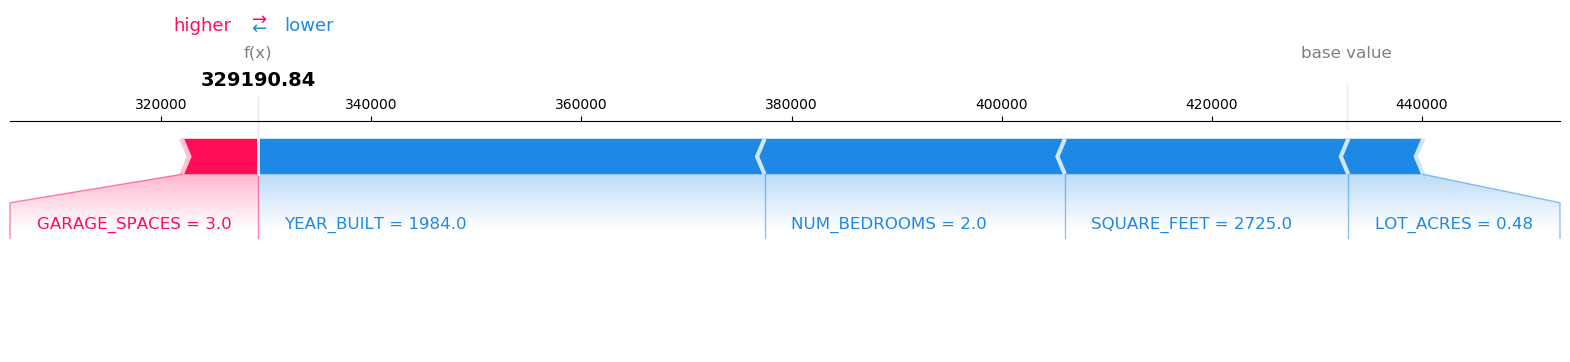

Visualize the SHAP values for Record number 2 with Model Prediction: 445172.375


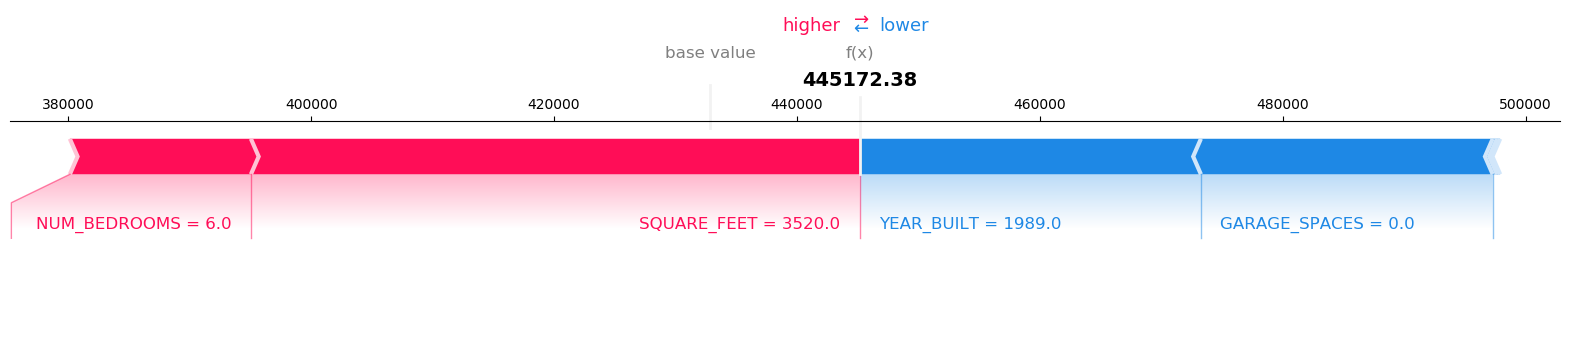

Visualize the SHAP values for Record number 3 with Model Prediction: 524527.75


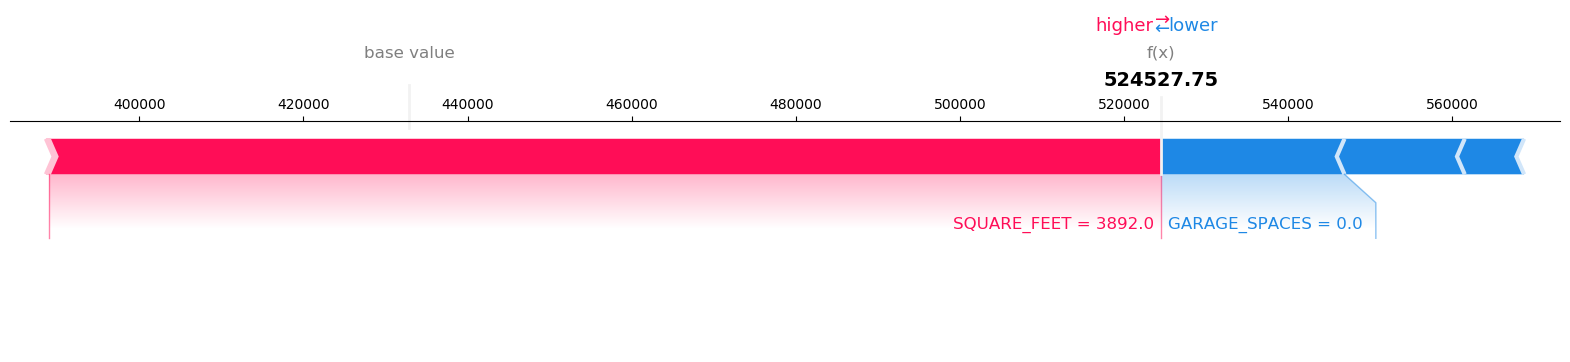

In [34]:
visualize_result(result, request_records, expected_value)

## Cleanup

Finally, don’t forget to clean up the resources we set up and used for this demo!

In [35]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'b9bcada7-1bea-4221-bae3-bf3ed701063c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b9bcada7-1bea-4221-bae3-bf3ed701063c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 31 Jan 2023 01:58:02 GMT'},
  'RetryAttempts': 0}}

In [36]:
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': 'a8764635-a66e-4384-b336-c34458f1bce2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a8764635-a66e-4384-b336-c34458f1bce2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 31 Jan 2023 01:58:02 GMT'},
  'RetryAttempts': 0}}

In [37]:
sagemaker_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'f21d7597-d866-45ec-9462-716282214e7c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f21d7597-d866-45ec-9462-716282214e7c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 31 Jan 2023 01:58:02 GMT'},
  'RetryAttempts': 0}}